In [180]:
from data_augmentation import augment_images
from feature_extraction import extract_lbp, create_histograms, extract_glcm_noloop
from utils import load_images, show_raw_images, crop_images, preprocess_images
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy as cp
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFECV

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, train_test_split
from sklearn.model_selection import LearningCurveDisplay

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

import seaborn as sns
sns.set_theme(style="ticks")

plt.rcParams['figure.dpi'] = 600

random_state = 8


Loading images...
|████████████████████████████████████████| 117/117 [100%] in 3.8s (31.18/s) 
|████████████████████████████████████████| 38/38 [100%] in 0.5s (70.63/s) 

Cropping images...
|████████████████████████████████████████| 117/117 [100%] in 7.9s (14.90/s) 
|████████████████████████████████████████| 38/38 [100%] in 1.7s (22.88/s) 


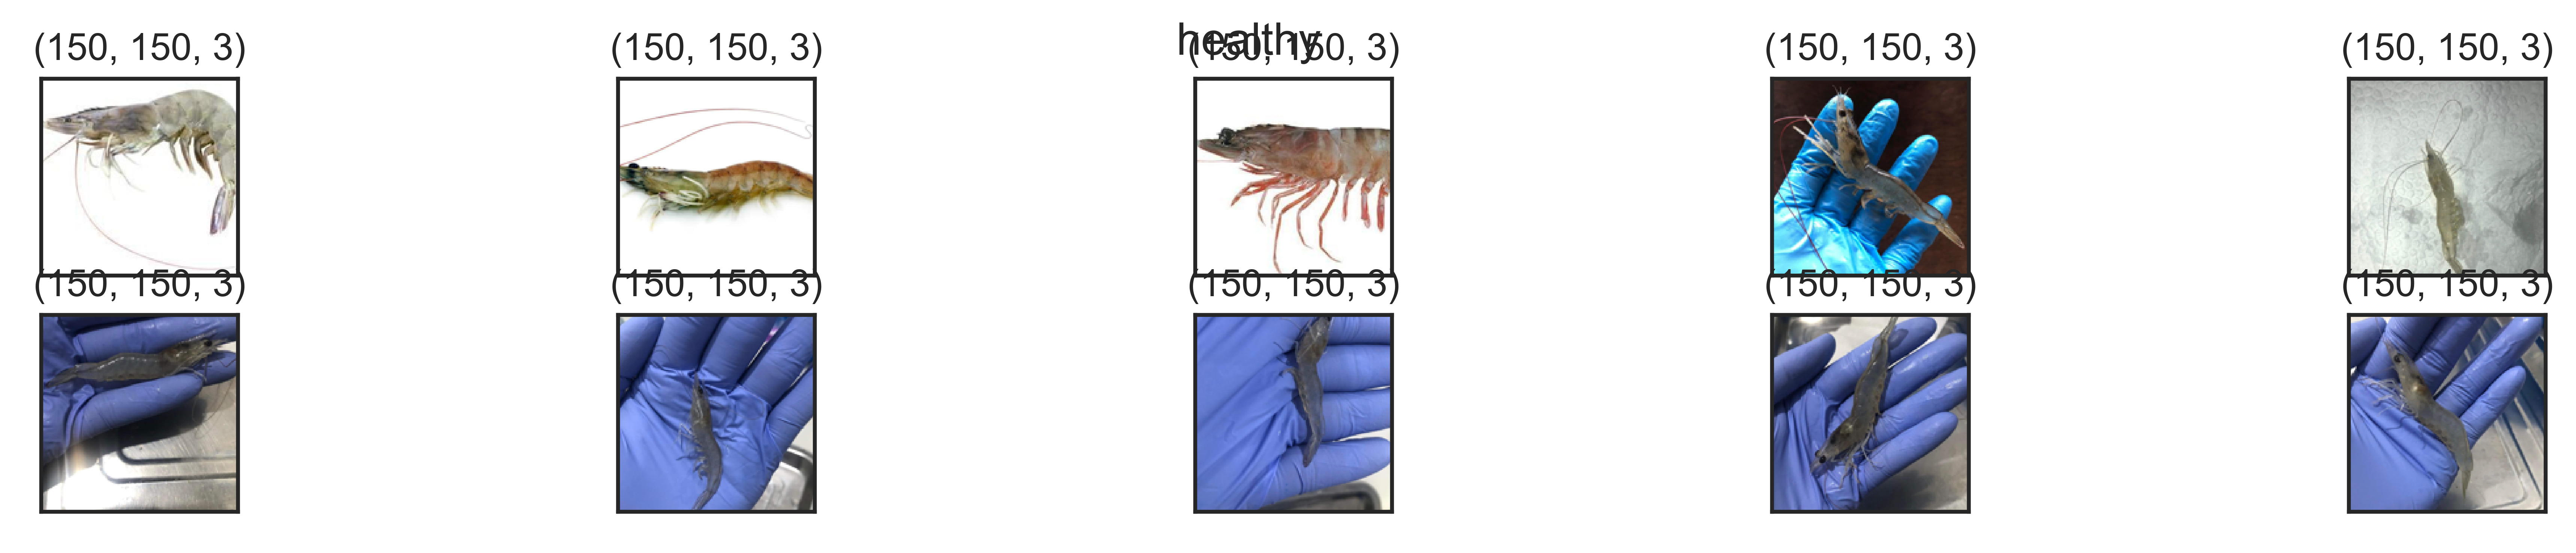

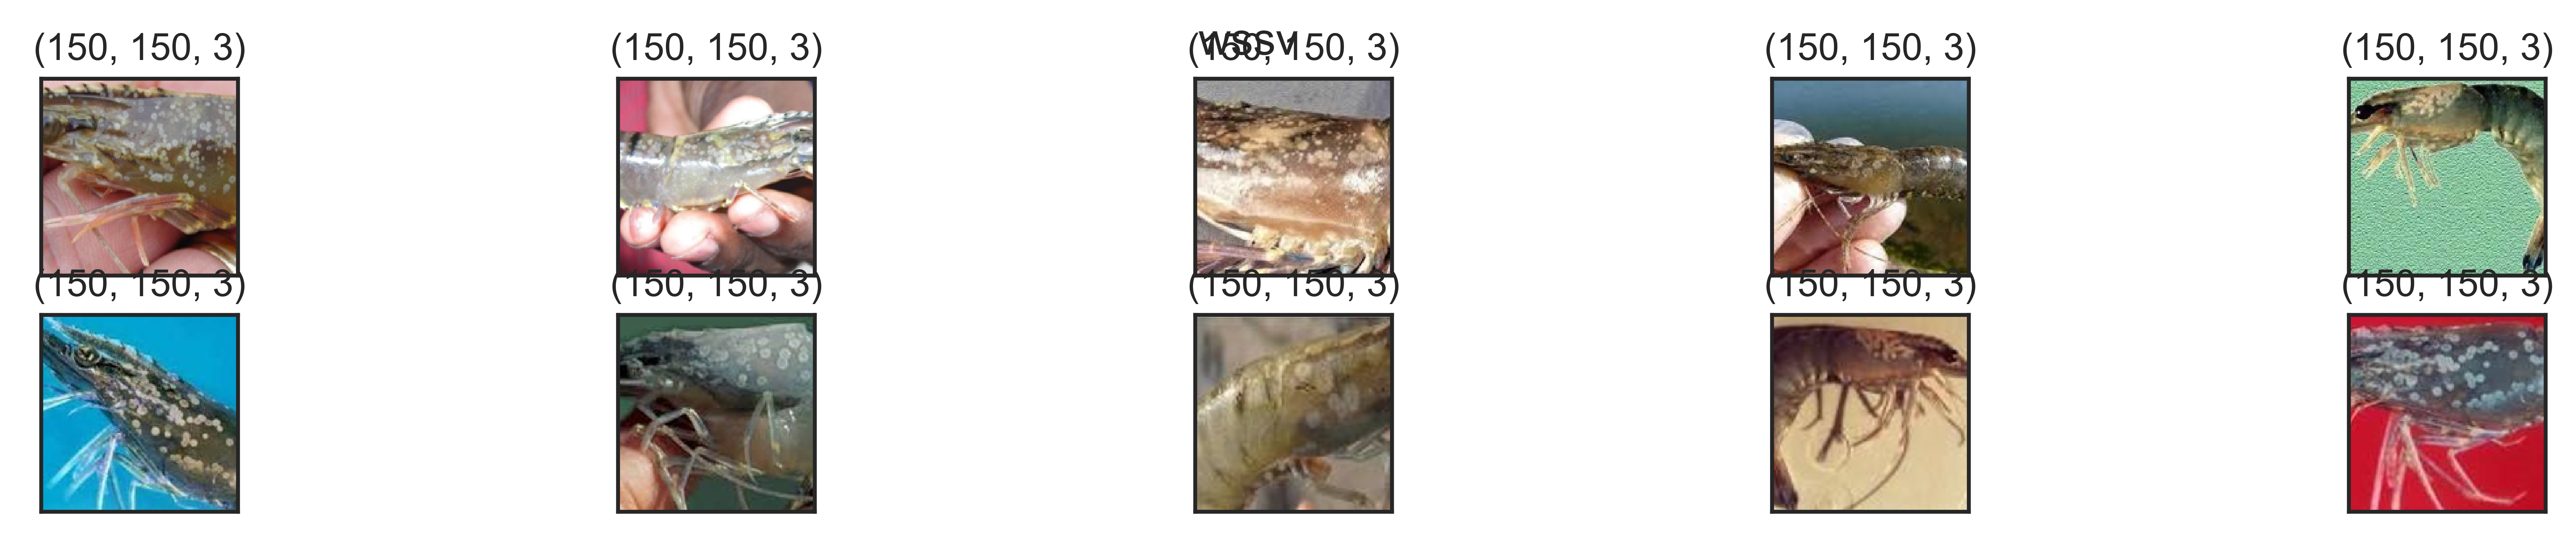


Preprocessing images...
|████████████████████████████████████████| 117/117 [100%] in 0.0s (11215.71/s) 
|████████████████████████████████████████| 38/38 [100%] in 0.0s (14650.32/s) 


In [181]:
main_dir = 'wssv-dataset/train'
main_dir2 = 'wssv-dataset'
classnames = ['healthy', 'wssv']

print("\nLoading images...")
class_0 = load_images(f'{main_dir}/healthy')
class_1 = load_images(f'{main_dir}/wssv')

class_0_num_samples = len(class_0)
class_1_num_samples = len(class_1)

print("\nCropping images...")
class_0_cropped = crop_images(class_0, 150)
class_1_cropped = crop_images(class_1, 150)

show_raw_images(class_0_cropped, classnames[0])
show_raw_images(class_1_cropped, classnames[1])

print("\nPreprocessing images...")
class_0_preprocessed = preprocess_images(class_0_cropped)
class_1_preprocessed = preprocess_images(class_1_cropped)

labels = np.array([0] * class_0_num_samples + [1] * class_1_num_samples)
all_images = np.vstack((class_0_preprocessed, class_1_preprocessed))
all_images = list(zip(all_images, labels))

x_train, x_test, y_train, y_test = train_test_split(all_images,
                                                    labels,
                                                    test_size=0.3,
                                                    random_state=random_state)

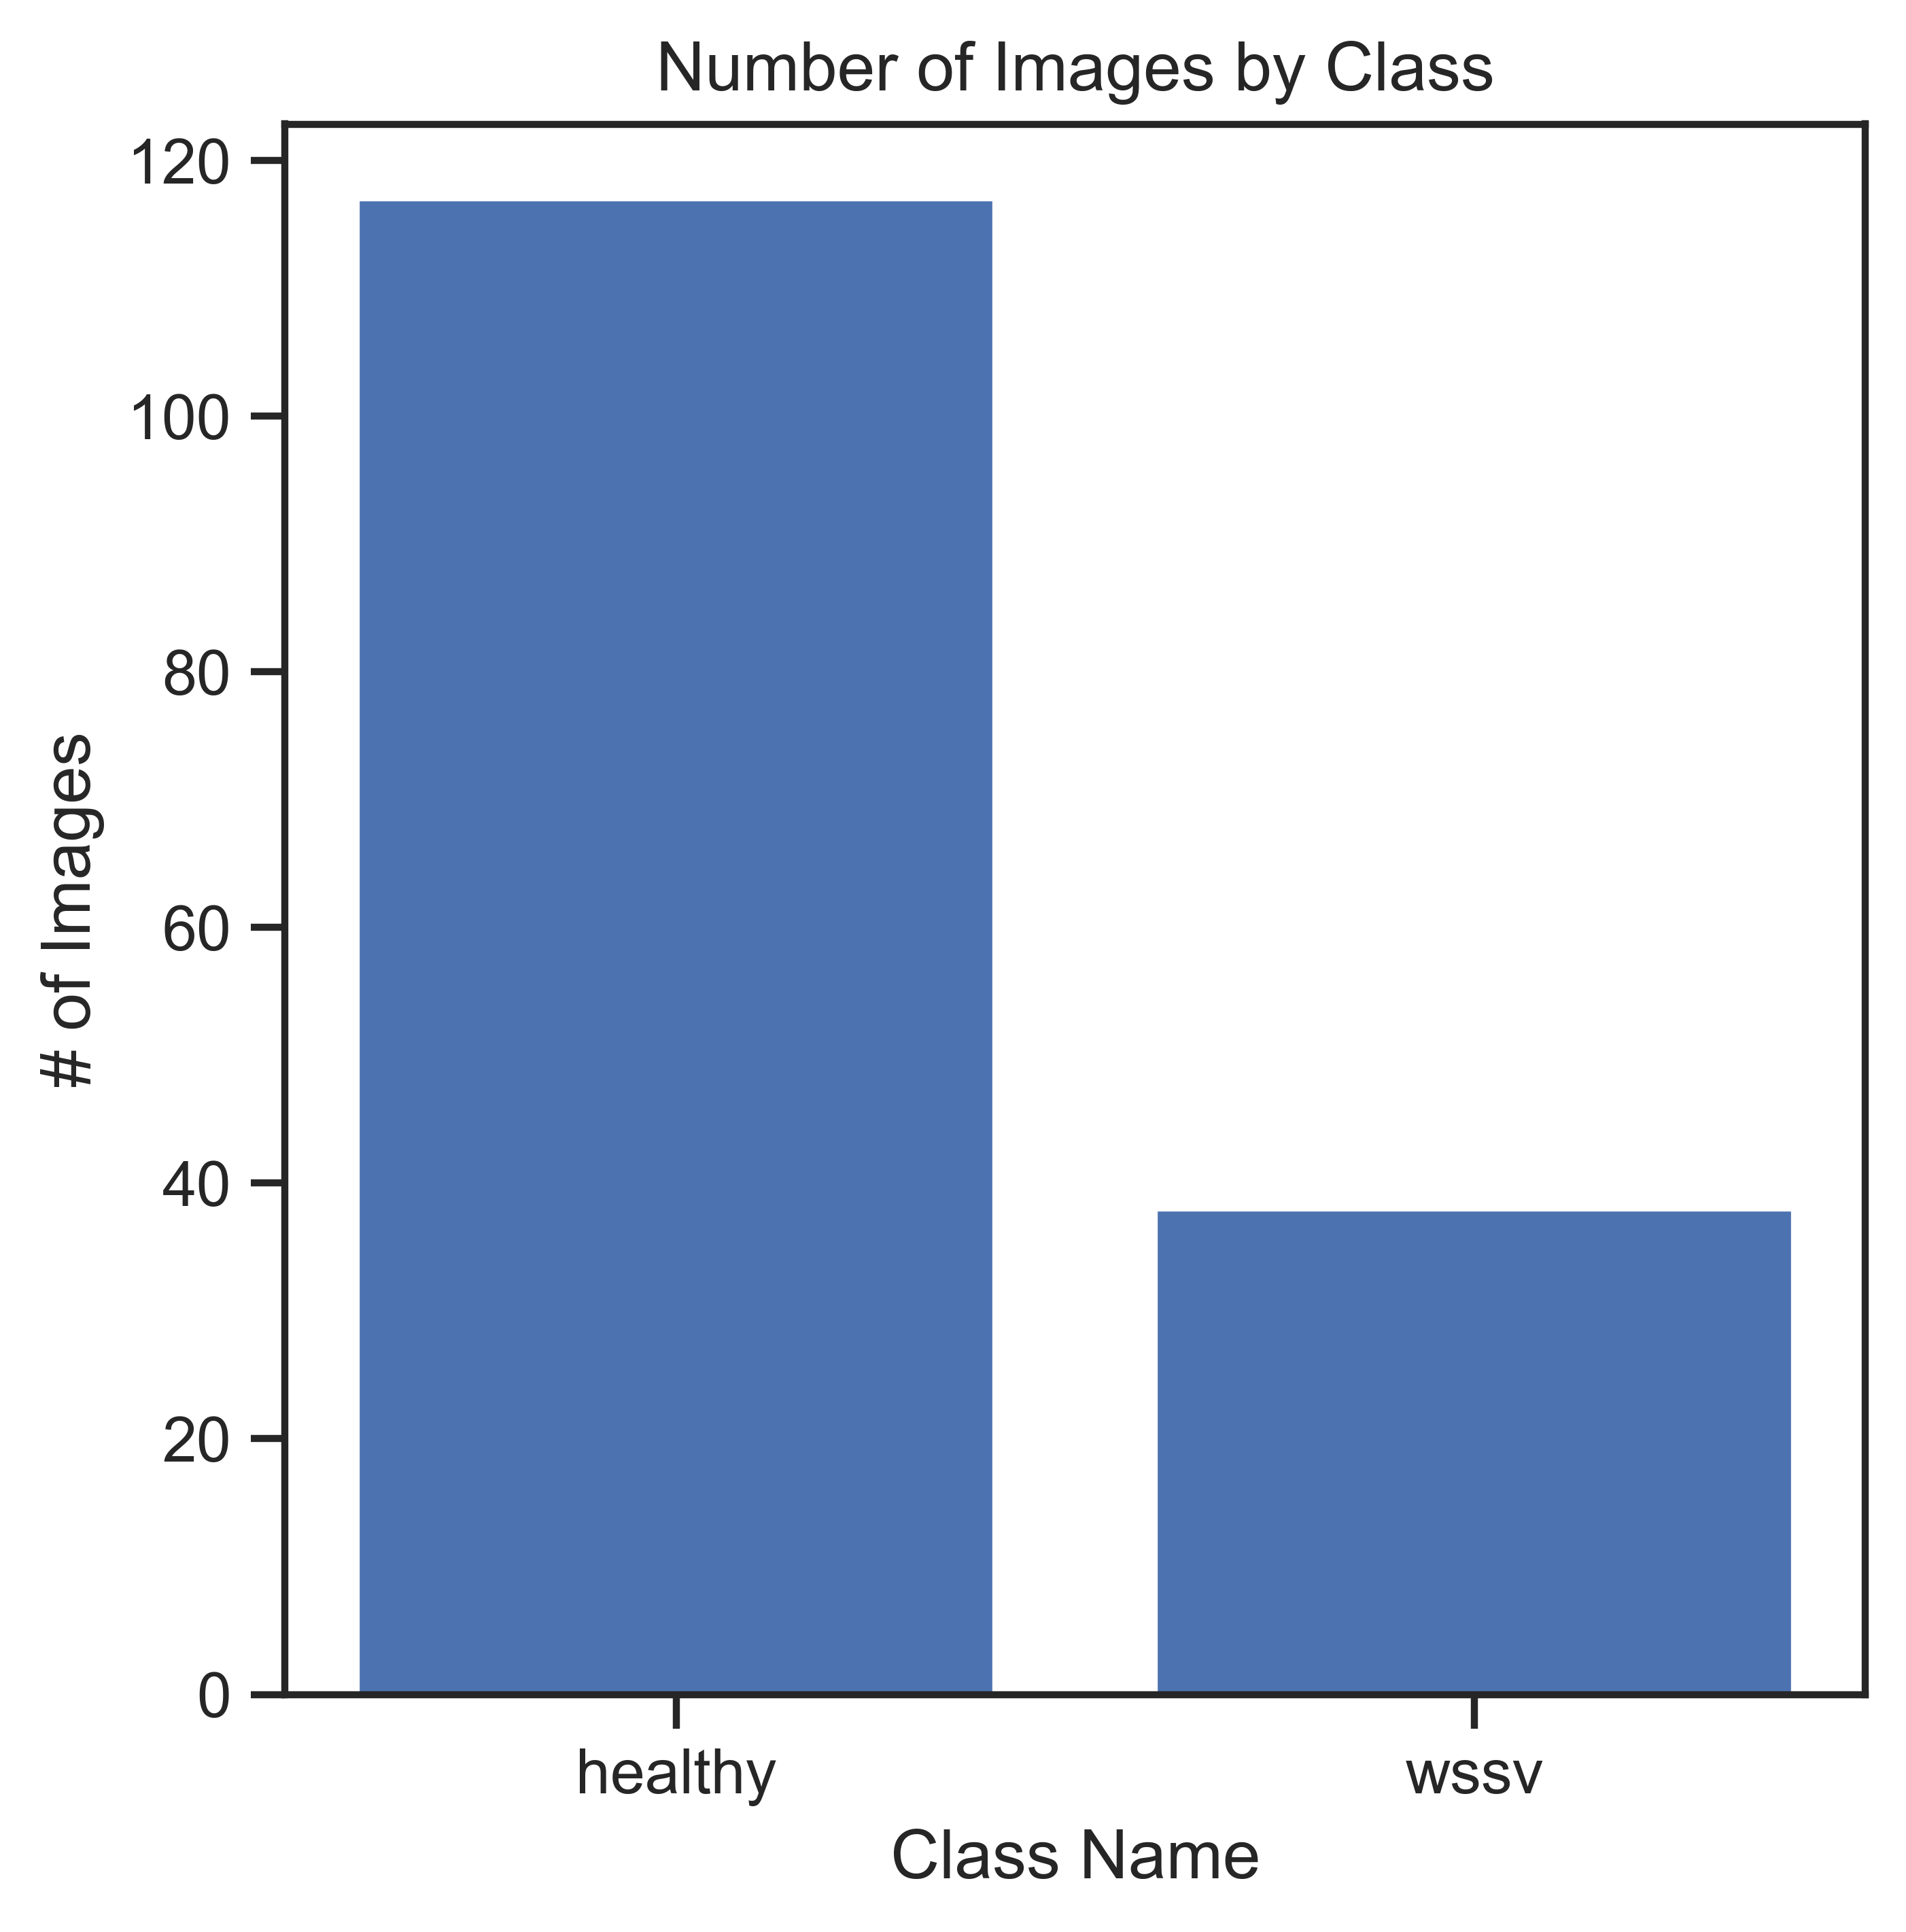

In [182]:
num_per_class = {'healthy': class_0_num_samples,
                 'wssv': class_1_num_samples}
idx_to_class = {0: 'healthy', 1: 'wssv'}

plt.bar(num_per_class.keys(), num_per_class.values())
plt.title("Number of Images by Class")
plt.xlabel('Class Name')
plt.ylabel('# of Images')
plt.show()


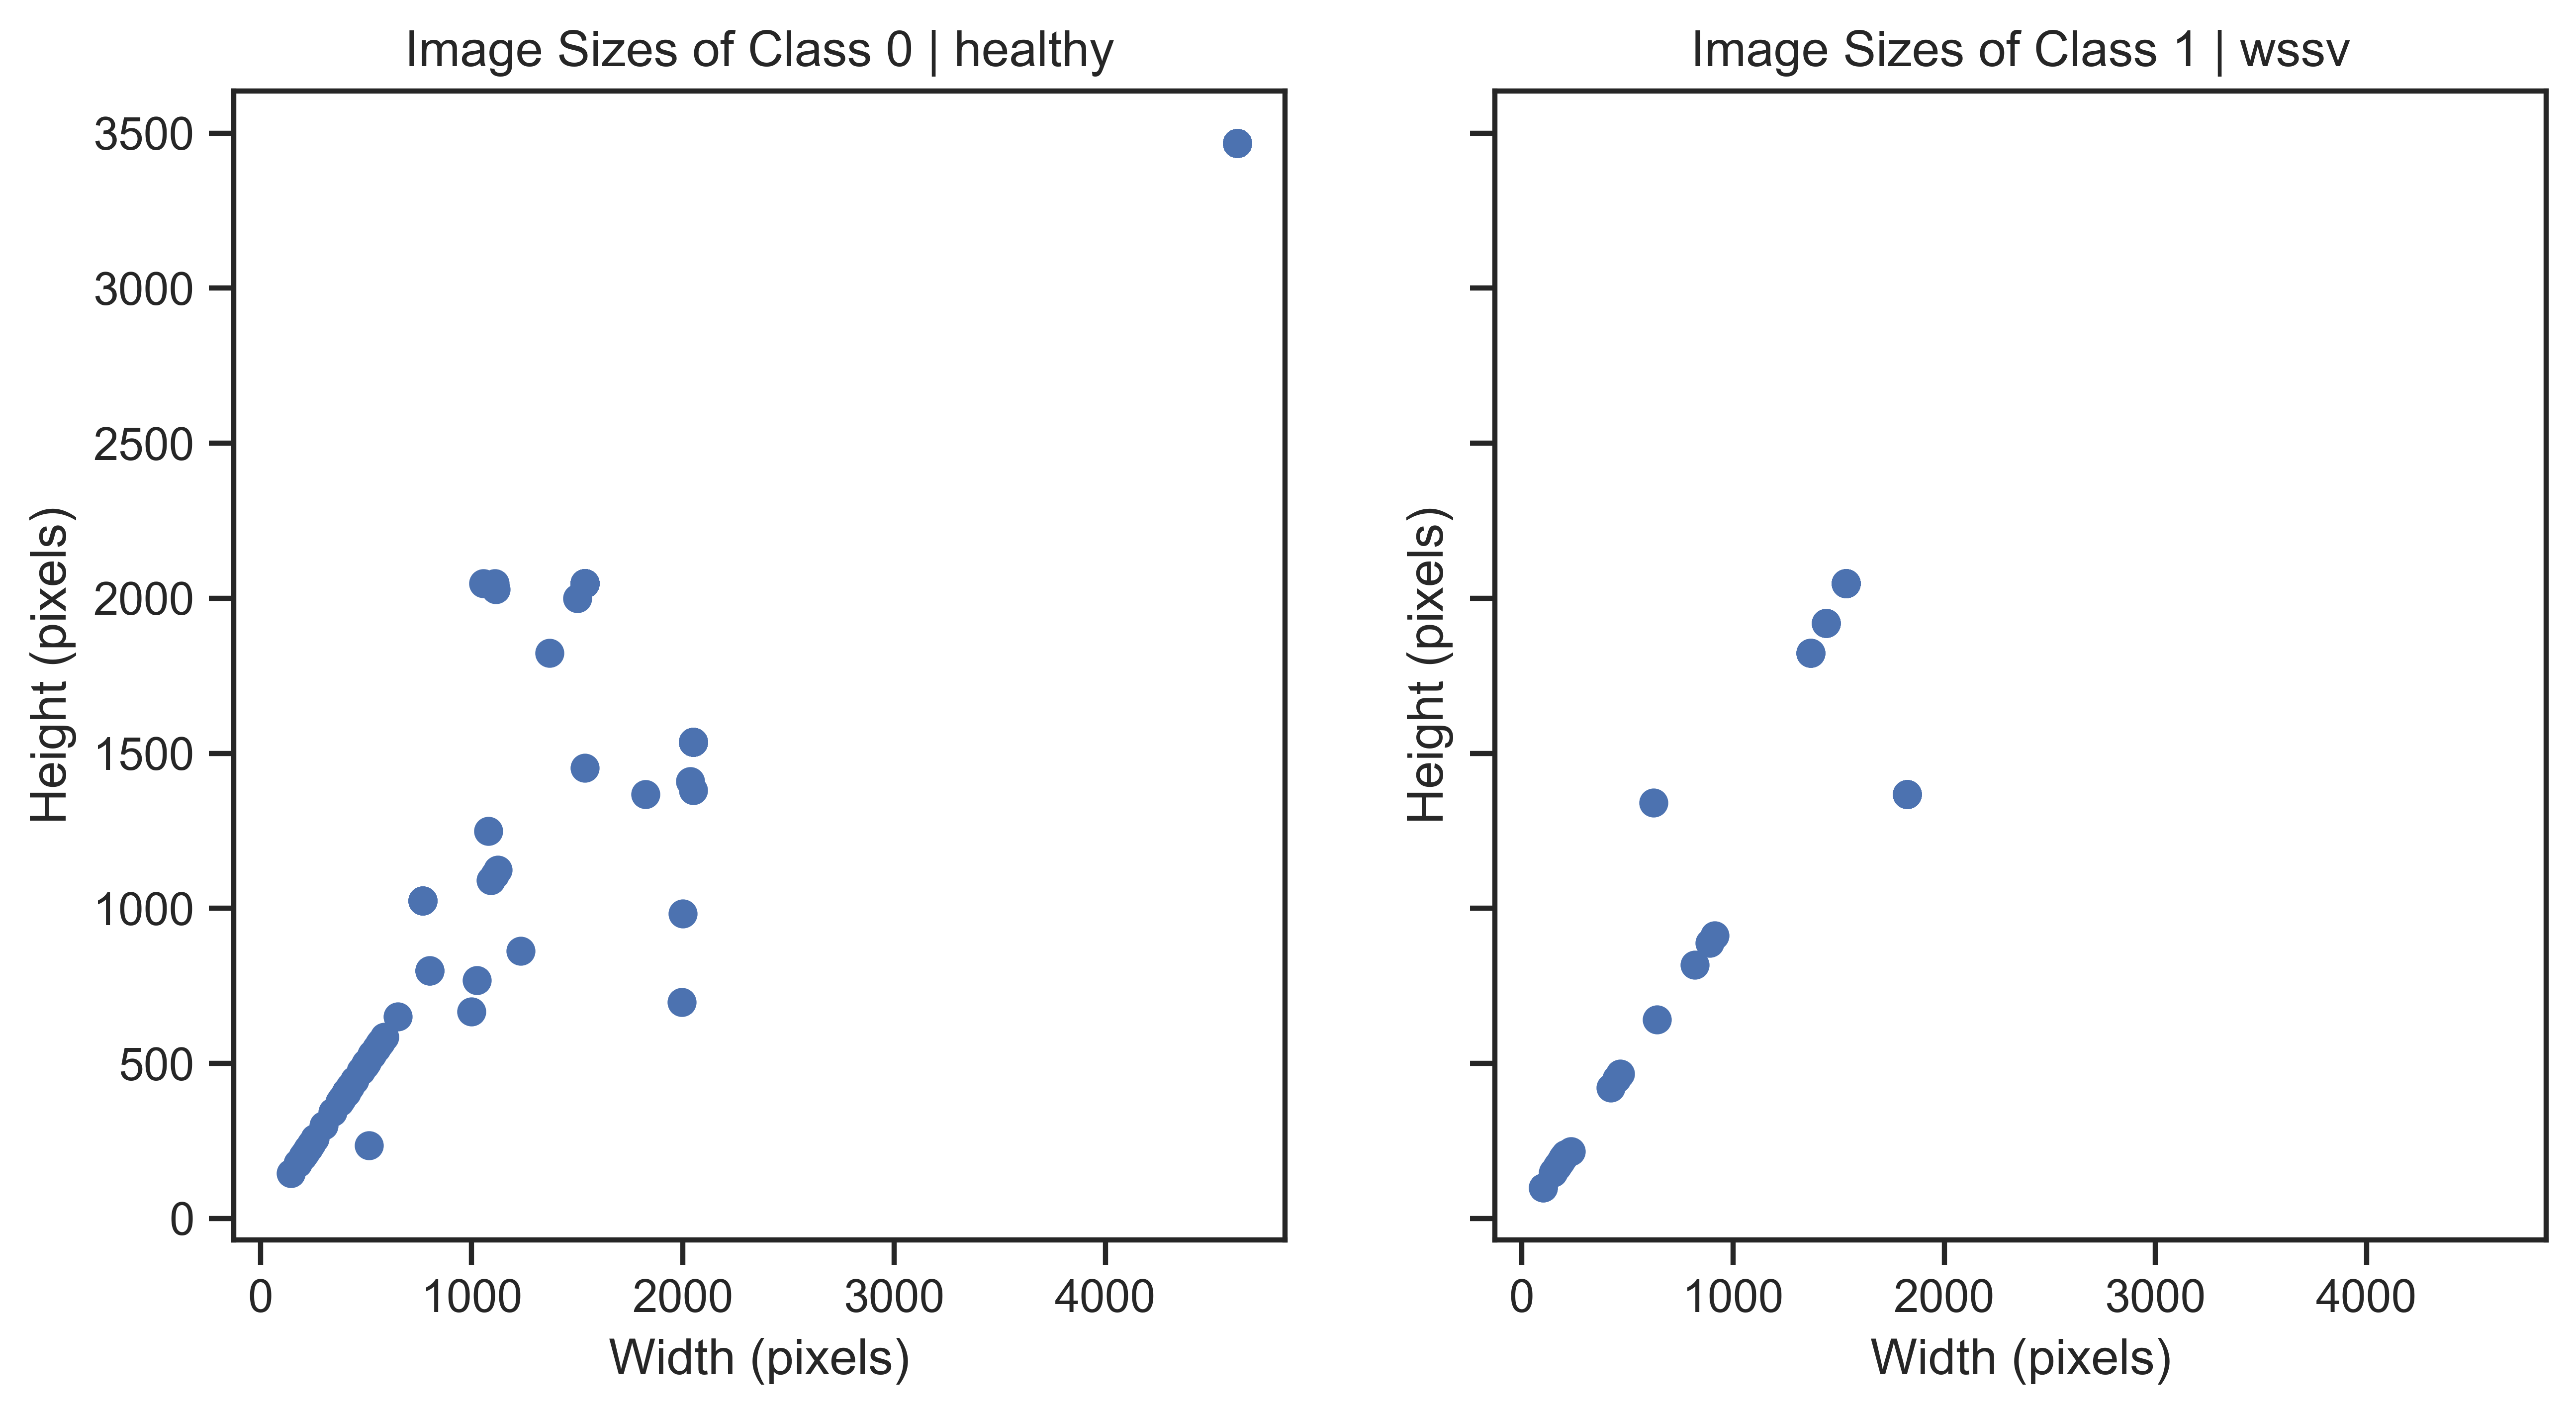

In [183]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
y_height_class0 = []
x_width_class0 = []
labels_class0 = []
for image in class_0:
    h, w, _ = image.shape
    y_height_class0.append(h)
    x_width_class0.append(w)
    labels_class0.append('healthy')
ax[0].scatter(x_width_class0, y_height_class0)
ax[0].set_ylabel('Height (pixels)')
ax[0].set_xlabel('Width (pixels)')
ax[0].set_title('Image Sizes of Class 0 | healthy')

y_height_class1 = []
x_width_class1 = []
labels_class1 = []
for image in class_1:
    h, w, _ = image.shape
    y_height_class1.append(h)
    x_width_class1.append(w)
    labels_class1.append('wssv')

res_arr = np.column_stack((
    np.hstack((labels_class0, labels_class1)),
    np.hstack((x_width_class0, x_width_class1)),
    np.hstack((y_height_class0, y_height_class1)),
))

res_df = pd.DataFrame(res_arr, columns=['class', 'width', 'height'])

ax[1].scatter(x_width_class1, y_height_class1)
ax[1].set_ylabel('Height (pixels)')
ax[1].set_xlabel('Width (pixels)')
ax[1].set_title('Image Sizes of Class 1 | wssv')
plt.show()


In [184]:
x_train_images = [i for i, j in x_train]
x_test_images = [i for i, j in x_test]


x_train_lbp = extract_lbp(x_train_images)
x_test_lbp = extract_lbp(x_test_images)

print("\nCreating Histograms...")
x_train_lbp_hist = create_histograms(x_train_lbp,
                                     sub_images_num=3,
                                     bins_per_sub_images=64)

x_test_lbp_hist = create_histograms(x_test_lbp,
                                    sub_images_num=3,
                                    bins_per_sub_images=64)


on 0: c:\Users\Enzo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
        warnings.warn(


|████████████████████████████████████████| 108/108 [100%] in 0.4s (297.42/s) 
|████████████████████████████████████████| 47/47 [100%] in 0.1s (314.82/s) 

Creating Histograms...
|████████████████████████████████████████| 108/108 [100%] in 0.1s (930.70/s) 
|████████████████████████████████████████| 47/47 [100%] in 0.1s (851.34/s) 


In [185]:
n_components = 10

def custom_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)

    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    f1 = f1_score(y_test, y_pred, average='weighted')
    fnr = FN/(TP+FN)
    fnr_healthy = fnr[0]
    fnr_wssv = fnr[1]
    acc = balanced_accuracy_score(y_test, y_pred)
    
    return {'f1': f1, 'acc': acc, 'fnr_healthy': fnr_healthy, 'fnr_wssv': fnr_wssv}


In [186]:
pipeline = Pipeline(steps=[('s', StandardScaler()),
                           ('p', PCA(n_components=n_components)),
                           ('m', SVC())
                           ])

cv = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=random_state)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_weighted']
scores = cross_validate(pipeline,
                        x_train_lbp_hist,
                        y_train,
                        scoring=custom_scorer,
                        cv=cv,
                        n_jobs=-1,
                        return_train_score=True)

print(scores)
print("\nWithout SMOTE and Tomek-Links")
print('\nTraining')
print('Accuracy: %.4f' % np.mean(scores['train_accuracy']))
print('False Negative Rate (Healthy): %.4f' % np.mean(scores['train_fnr_healthy']))
print('False Negative Rate (WSSV): %.4f' % np.mean(scores['train_fnr_wssv']))
# print('Precision: %.4f' % np.mean(scores['train_precision_macro']))
# print('Recall: %.4f' % np.mean(scores['train_recall_macro']))
print('F1 Score: %.4f' % np.mean(scores['train_f1_weighted']))

print('\nValidation')
print('\nAccuracy: %.4f' % np.mean(scores['test_accuracy']))
print('False Negative Rate (Healthy): %.4f' % np.mean(scores['test_fnr_healthy']))
print('False Negative Rate (WSSV): %.4f' % np.mean(scores['test_fnr_wssv']))
# print('Precision: %.4f' % np.mean(scores['test_precision_macro']))
# print('Recall: %.4f' % np.mean(scores['test_recall_macro']))
print('F1 Score: %.4f' % np.mean(scores['test_f1_weighted']))

pipeline.fit(x_train_lbp_hist, y_train)
y_preds_svm = pipeline.predict(x_test_lbp_hist)

score_svm_test = np.round(pipeline.score(x_test_lbp_hist, y_test) * 100, 2)
f1_svm = f1_score(y_test, y_preds_svm)

cm = confusion_matrix(y_test, y_preds_svm, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classnames)

FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FNR = FN/(TP+FN)

print('\nTest')
print('\nTest F1 score: %.4f' % f1_svm)
print('Test False Negative Rate (Healthy): %.4f' % FNR[0])
print('Test False Negative Rate (WSSV): %.4f' % FNR[1])

disp.plot()
plt.show()


{'fit_time': array([0.00700188, 0.00500131, 0.00600123, 0.00500083, 0.006001  ]), 'score_time': array([0.00300074, 0.00300074, 0.00500131, 0.00200033, 0.00300074]), 'test_accuracy': array([0.81818182, 0.72727273, 0.72727273, 0.80952381, 0.76190476]), 'train_accuracy': array([0.84883721, 0.80232558, 0.8372093 , 0.90804598, 0.90804598]), 'test_precision_macro': array([0.9047619 , 0.36363636, 0.36363636, 0.9       , 0.66176471]), 'train_precision_macro': array([0.91558442, 0.89634146, 0.91139241, 0.94520548, 0.94520548]), 'test_recall_macro': array([0.6   , 0.5   , 0.5   , 0.6   , 0.6375]), 'train_recall_macro': array([0.70454545, 0.5952381 , 0.66666667, 0.81818182, 0.81818182]), 'test_f1_weighted': array([0.76714514, 0.61244019, 0.61244019, 0.75661376, 0.75228475]), 'train_f1_weighted': array([0.82411028, 0.74654643, 0.80442506, 0.9004942 , 0.9004942 ])}

Without SMOTE and Tomek-Links

Training
Accuracy: 0.8609


KeyError: 'train_fnr_healthy'


After Applying SMOTE and Tomek-Links

Training
Accuracy: 0.9375
Precision: 0.9079
Recall: 0.9369
F1 Score: 0.9387

Validation

Accuracy: 0.7494
Precision: 0.7017
Recall: 0.6628
F1 Score: 0.7461

Test

Test F1 score: 0.7826
Test False Negative Rate (Healthy): 0.0833
Test False Negative Rate (WSSV): 0.1818


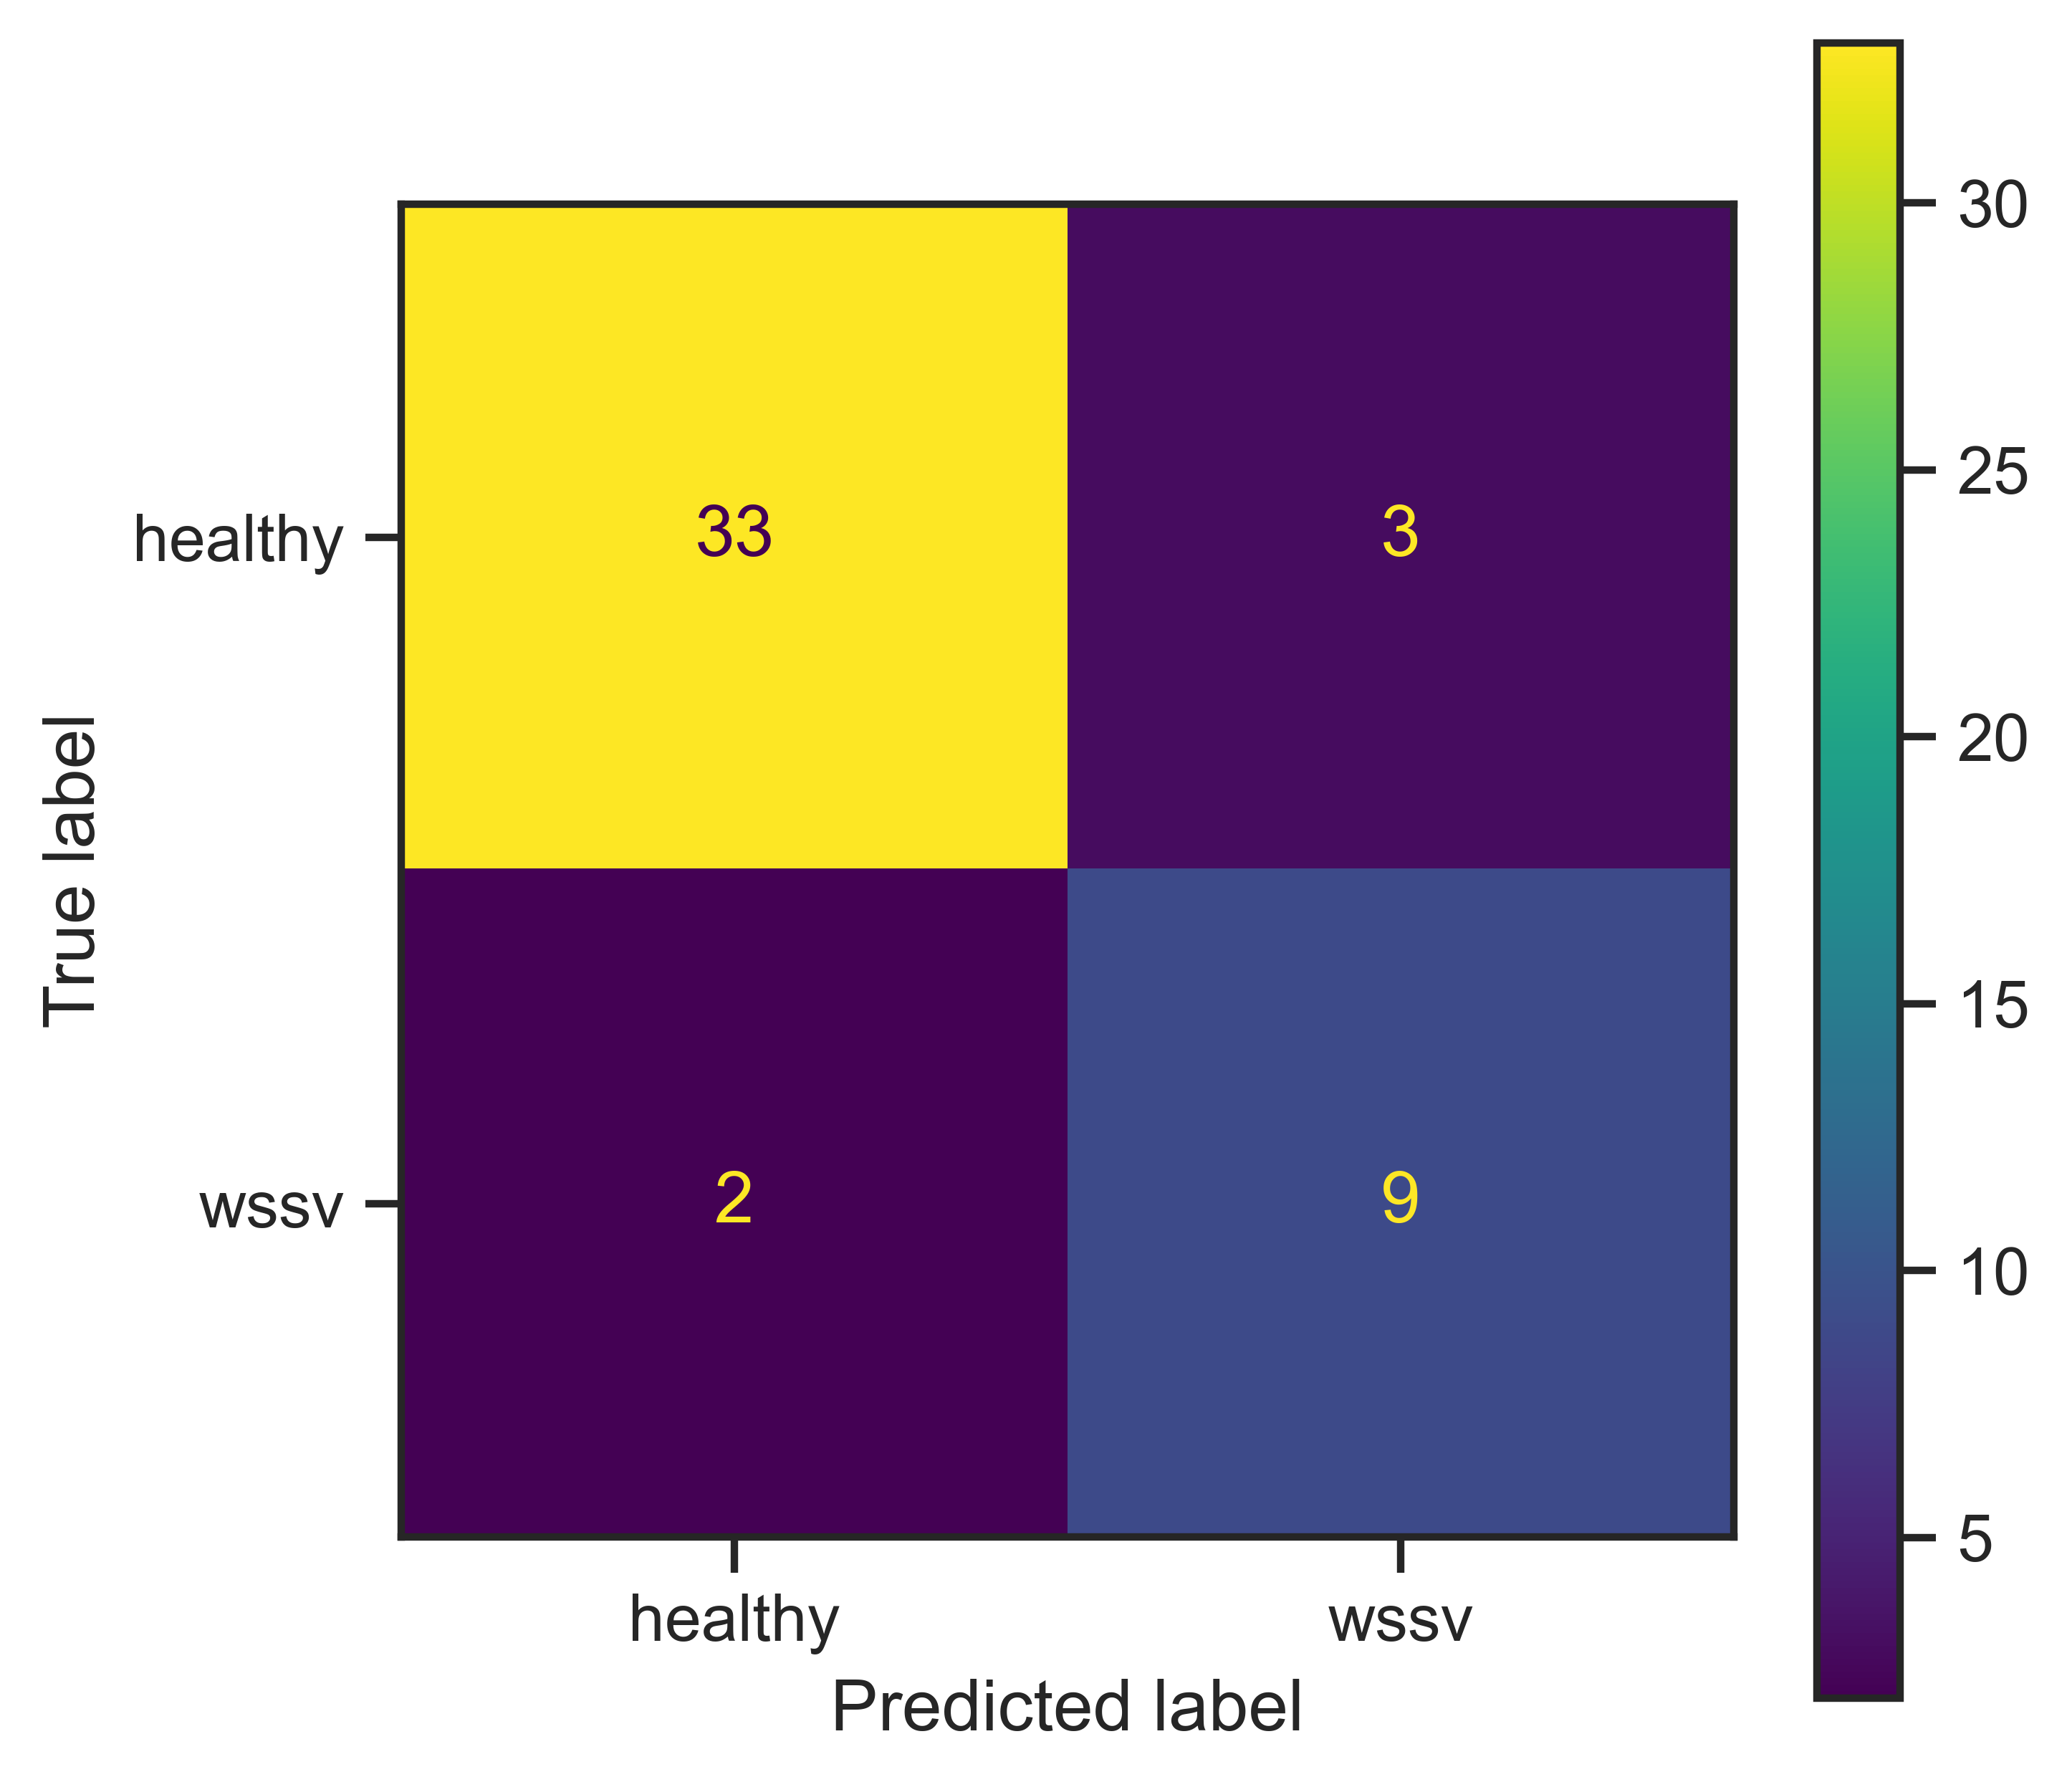

In [ ]:
pipeline = Pipeline(steps=[('s', StandardScaler()),
                           ('r', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'),
                                            smote=SMOTE(sampling_strategy='minority'))),
                           ('p', PCA(n_components=n_components)),
                           ('m', SVC())
                           ])

cv = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=random_state)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_weighted']
scores = cross_validate(pipeline,
                        x_train_lbp_hist,
                        y_train,
                        scoring=scoring,
                        cv=cv,
                        n_jobs=-1,
                        return_train_score=True)

print("\nAfter Applying SMOTE and Tomek-Links")
print('\nTraining')
print('Accuracy: %.4f' % np.mean(scores['train_accuracy']))
print('Precision: %.4f' % np.mean(scores['train_precision_macro']))
print('Recall: %.4f' % np.mean(scores['train_recall_macro']))
print('F1 Score: %.4f' % np.mean(scores['train_f1_weighted']))

print('\nValidation')
print('\nAccuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Recall: %.4f' % np.mean(scores['test_recall_macro']))
print('F1 Score: %.4f' % np.mean(scores['test_f1_weighted']))

pipeline.fit(x_train_lbp_hist, y_train)
y_preds_svm = pipeline.predict(x_test_lbp_hist)

score_svm_test = np.round(pipeline.score(x_test_lbp_hist, y_test) * 100, 2)
f1_svm = f1_score(y_test, y_preds_svm)

cm = confusion_matrix(y_test, y_preds_svm, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classnames)

FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FNR = FN/(TP+FN)

print('\nTest')
print('\nTest F1 score: %.4f' % f1_svm)
print('Test False Negative Rate (Healthy): %.4f' % FNR[0])
print('Test False Negative Rate (WSSV): %.4f' % FNR[1])

disp.plot()
plt.show()